# Testing UniRef Model

In [1]:
import torch
from transformers import T5EncoderModel, T5Tokenizer
import re
import numpy as np

# Load model
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False)
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")

# Load into GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#model = model.to(device)
#model = model.eval() 

Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.11.layer.1.EncDecAttention.o.weight', 'decoder.block.18.layer.0.SelfAttention.q.weight', 'decoder.block.22.layer.2.DenseReluDense.wo.weight', 'decoder.block.6.layer.0.SelfAttention.v.weight', 'decoder.block.1.layer.1.EncDecAttention.q.weight', 'decoder.block.16.layer.0.layer_norm.weight', 'decoder.block.14.layer.2.DenseReluDense.wo.weight', 'decoder.block.6.layer.0.SelfAttention.q.weight', 'decoder.block.9.layer.0.SelfAttention.v.weight', 'decoder.block.12.layer.0.layer_norm.weight', 'decoder.block.23.layer.2.layer_norm.weight', 'decoder.block.6.layer.0.SelfAttention.k.weight', 'decoder.block.16.layer.1.EncDecAttention.k.weight', 'decoder.block.2.layer.1.layer_norm.weight', 'decoder.block.16.layer.2.DenseReluDense.wo.weight', 'decoder.block.23.layer.2.DenseReluDense.wo.weight', 'decoder.block.19.layer.0.SelfAttention.v.weight', 'decoder.block.1.layer.2.Den

In [2]:
# Tokenize, encode, and load example sequences
ex_seq = ["A T W","A T E"]
ex_seq = [re.sub(r"[UZOB]", "X", sequence) for sequence in ex_seq]
ids = tokenizer.batch_encode_plus(ex_seq, add_special_tokens=True, padding=True)
input_ids = torch.tensor(ids['input_ids']).to(device)
attention_mask = torch.tensor(ids['attention_mask']).to(device)

# Extract sequence features
with torch.no_grad():
    embedding = model(input_ids=input_ids,attention_mask=attention_mask)
embedding = embedding.last_hidden_state.cpu().numpy()

# Remove padding and special tokens
features = [] 
for seq_num in range(len(embedding)):
    seq_len = (attention_mask[seq_num] == 1).sum()
    seq_emd = embedding[seq_num][:seq_len-1]
    features.append(seq_emd)
len(features)

2

# Encoding Real Protein Sequences

In [3]:
from Bio import SeqIO

# Use biopython to parse fasta file and append sequences to list
sequences = []
with open("sequence.fasta") as file:
    for seq in SeqIO.parse(file, 'fasta'):

        # Add space after each character so each amino acid is vectorized
        seq = str(seq.seq)
        seq = ' '.join([*seq])
        sequences.append(seq)

# Use two sequences for testing
seq1 = sequences[4]
seq2 = sequences[6]
sequences = [seq1, seq2]

In [4]:
# Tokenize, encode, pad
ids = tokenizer.batch_encode_plus(sequences, add_special_tokens=True, padding=True)
input_ids = torch.tensor(ids['input_ids']).to(device)
attention_mask = torch.tensor(ids['attention_mask']).to(device)

# Extract sequence features
with torch.no_grad():
    embedding = model(input_ids=input_ids,attention_mask=attention_mask)  #decoder_input_ids for decoder weights
embedding = embedding.last_hidden_state.cpu().numpy()

# Remove padding and special tokens
features = [] 
for seq_num in range(len(embedding)):
    seq_len = (attention_mask[seq_num] == 1).sum()
    seq_emd = embedding[seq_num][:seq_len-1]
    features.append(seq_emd)
len(features)

2

Number of vectors is half the length of a sequence with individual amino acids due to the space characters delineating each residue.

# Finding Significant Cosine Similarity Between Embedded Amino Acids

In [2]:
import os
from datetime import datetime
from Bio import SeqIO


def write_align(seq1, seq2, id1, id2):
    """=============================================================================================
    This function accepts two sequences after gaps have been introduced and writes them to a file
    in MSF format.

    :param seq1: first aligned sequence
    :param seq2: second aligned sequence
    :param id1: first sequence id
    :param id2: second sequence id
    ============================================================================================="""

    # Add space every 10 characters
    seq1 = [seq1[i:i+10] for i in range(0, len(seq1), 10)]
    seq1 = ' '.join(seq1)
    seq2 = [seq2[i:i+10] for i in range(0, len(seq2), 10)]
    seq2 = ' '.join(seq2)

    # Split sequences every 50 characters
    seq1_split = [seq1[i:i+55] for i in range(0, len(seq1), 55)]
    seq2_split = [seq2[i:i+55] for i in range(0, len(seq2), 55)]

    if len(id1) != len(id2):
        if len(id1) > len(id2):
            id2 = id2 + ' ' * (len(id1) - len(id2))
        else:
            id1 = id1 + ' ' * (len(id2) - len(id1))

    # Write to a new line for every index in the split list i.e. every 55 characters
    if not os.path.isdir('alignments'):
        os.makedirs('alignments')
    with open(f'alignments/{datetime.now()}.txt', 'w', encoding='utf8') as file:
        file.write('PileUp\n\n\n\n')
        file.write(f'   MSF:  {len(seq1)}  Type:  P\n\n')
        file.write(f' Name: {id1} oo  Len:  {len(seq1)}\n')
        file.write(f' Name: {id2} oo  Len:  {len(seq2)}\n\n//\n\n\n\n')
        for i in range(len(seq1_split)):  # pylint: disable=C0200
            file.write(f'{id1}      {seq1_split[i]}\n')
            file.write(f'{id2}      {seq2_split[i]}\n\n')


def parse_fasta(filename):
    """=============================================================================================
    This function accepts a fasta file name and returns the sequence and its ids.

    :param filename: name of file
    return: sequence and id
    ============================================================================================="""

    seq = ''
    with open(filename, 'r', encoding='utf8') as file:
        for seq in SeqIO.parse(file, 'fasta'):
            name = seq.id
            seq = str(seq.seq)
    return seq, name

In [8]:
import numpy as np
import blosum as bl


def global_align(seq1, seq2, subs_matrix, gopen, gext):
    """=============================================================================================
    This function accepts two sequences, creates a matrix corresponding to their lengths, and
    calculates the score of the alignments for each index. A second matrix is scored so that the
    best alignment can be tracebacked.

    :param seq1: first sequence
    :param seq2: second sequence
    :param subs_matrix: substitution scoring matrix (i.e. BLOSUM62)
    :param gopen: gap penalty for opening a new gap
    :param gext: gap penalty for extending a gap
    return: traceback matrix
    ============================================================================================="""

    # Initialize scoring and traceback matrix based on sequence lengths
    row_length = len(seq1)+1
    col_length = len(seq2)+1
    score_m = np.full((row_length, col_length), 0)
    trace_m = np.full((row_length, col_length), 0)

    # Initialize first row and column with gap values for S matrix, traceback values for T matrix
    for i in range(1, len(score_m[0])):
        score_m[0][i] = gopen+gext*i+1  # +1 to offset i starting at 1
        trace_m[0][i] = -1
    for i in range(1, len(score_m.T[0])):
        score_m.T[0][i] = gopen+gext*i+1
        trace_m.T[0][i] = 1


    '''TESTING CODE'''
    blosum_scores = []

    # Score matrix by moving through each index
    gap = False
    for i, char in enumerate(seq1):
        seq1_char = char  # Character in 1st sequence
        for j, char in enumerate(seq2):
            seq2_char = char  # Character in 2nd sequence

            # Preceding scoring matrix values
            diagonal = score_m[i][j]
            horizontal = score_m[i+1][j]
            vertical = score_m[i][j+1]

            # Score pair of residues based off BLOSUM matrix
            matrix_score = subs_matrix[f'{seq1_char}{seq2_char}']

            # Add to matrix values via scoring method
            diagonal += matrix_score
            if gap is False:  # Apply gap_open penalty if there is no gap
                horizontal += gopen
                vertical += gopen
            if gap is True:  # Apply gap_extension penalty if there is a gap
                horizontal += gext
                vertical += gext

            # Update gap status
            score = max(diagonal, horizontal, vertical)
            if score == diagonal:
                trace_m[i+1][j+1] = 0
                gap = False
            if score == horizontal:
                trace_m[i+1][j+1] = -1
                gap = True
            if score == vertical:
                trace_m[i+1][j+1] = 1
                gap = True

            # Assign value to scoring matrix
            score_m[i+1][j+1] = score

            '''TESTING CODE'''
            if trace_m[i+1][j+1] == 0:
                blosum_scores.append(matrix_score)

    return trace_m, blosum_scores


def traceback(trace_m, seq1, seq2):
    """=============================================================================================
    This function accepts a scoring and a traceback matrix and two sequences and returns global
    alignment between the two sequences

    :param trace_m: traceback matrix
    :param seq1: first sequence
    :param seq2: second sequence
    return: seq1 with gaps, seq2 with gaps
    ============================================================================================="""

    # Reverse strings and convert to lists so gaps can be inserted
    rev_seq1 = list(seq1[::-1])
    rev_seq2 = list(seq2[::-1])

    # Move through matrix starting at bottom right
    rows, cols = trace_m.shape
    index = [rows-1, cols-1]
    count = 0
    while index != [0, 0]:
        val = trace_m[index[0], index[1]]
        if val == 1:  # If cell is equal to 1, insert a gap into the second sequence
            index[0] = max(index[0] - 1, 0)  # Taking max of new index and 0 so index never below 0
            rev_seq2.insert(count, '.')
        if val == -1:  # If cell is equal to -1, insert a gap into the first sequence
            index[1] = max(index[1] - 1, 0)
            rev_seq1.insert(count, '.')
        if val == 0:  # If cell is equal to 0, there is no gap
            index[0] = max(index[0] - 1, 0)
            index[1] = max(index[1] - 1, 0)
        count += 1

    # Join lists and reverse strings again
    seq1 = ''.join(rev_seq1)
    seq2 = ''.join(rev_seq2)
    seq1 = seq1[::-1]
    seq2 = seq2[::-1]

    # Introduce gaps at end of either sequence based off length of other sequence
    align1 = seq1+"."*max(0, len(seq2)-len(seq1))
    align2 = seq2+"."*max(0, len(seq1)-len(seq2))
    return align1, align2

# Parse fasta files for sequences and ids
seq1, id1 = parse_fasta('sequences/BB11004_1.fa')
seq2, id2 = parse_fasta('sequences/BB11004_2.fa')

# Intialize BLOSUM matrix
blosum = bl.BLOSUM(62)

# Call global_align() to get traceback matrix
trace_m, blosum_scores = global_align(seq1, seq2, blosum, -11, -1)

# Get global alignment between seq1 and seq2 and write to file
align1, align2 = traceback(trace_m, seq1, seq2)
write_align(align1, align2, id1, id2)  # pylint: disable=E1121

In [12]:
import torch
import numpy as np
from transformers import T5EncoderModel, T5Tokenizer


def embed_seq(seq, tokenizer, encoder):
    """=============================================================================================
    This function accepts a protein sequence and returns a list of vectors, each vector representing
    a single amino acid.

    :param seq: protein sequence
    :param: tokenizer: tokenizer model
    :param encoder: encoder model
    return: list of vectors
    ============================================================================================="""

    # Add space after each amino acid so each residue is vectorized
    seq = [' '.join([*seq])]

    # Tokenize, encode, and load sequence
    ids = tokenizer.batch_encode_plus(seq, add_special_tokens=True, padding=True)
    input_ids = torch.tensor(ids['input_ids'])  # pylint: disable=E1101
    attention_mask = torch.tensor(ids['attention_mask'])  # pylint: disable=E1101

    # Extract sequence features
    with torch.no_grad():
        embedding = encoder(input_ids=input_ids,attention_mask=attention_mask)
    embedding = embedding.last_hidden_state.cpu().numpy()

    # Remove padding and special tokens
    features = []
    for seq_num in range(len(embedding)):  # pylint: disable=C0200
        seq_len = (attention_mask[seq_num] == 1).sum()
        seq_emd = embedding[seq_num][:seq_len-1]
        features.append(seq_emd)
    return features[0]


def global_align(seq1, seq2, vecs1, vecs2, gopen, gext):
    """=============================================================================================
    This function accepts two sequences, creates a matrix corresponding to their lengths, and
    calculates the score of the alignments for each index. A second matrix is scored so that the
    best alignment can be tracebacked.

    :param seq1: first sequence
    :param seq2: second sequence
    :param vecs1: list of vectors for first sequence
    :param vecs2: list of vectors for second sequence
    :param gopen: gap penalty for opening a new gap
    :param gext: gap penalty for extending a gap
    return: traceback matrix
    ============================================================================================="""

    # Initialize scoring and traceback matrix based on sequence lengths
    row_length = len(seq1)+1
    col_length = len(seq2)+1
    score_m = np.full((row_length, col_length), 0)
    trace_m = np.full((row_length, col_length), 0)

    # Initialize first row and column with gap values for S matrix, traceback values for T matrix
    for i in range(1, len(score_m[0])):
        score_m[0][i] = gopen+gext*i+1  # +1 to offset i starting at 1
        trace_m[0][i] = -1
    for i in range(1, len(score_m.T[0])):
        score_m.T[0][i] = gopen+gext*i+1
        trace_m.T[0][i] = 1

    '''TESTING CODE'''
    cos_scores = []

    # Score matrix by moving through each index
    gap = False
    for i in range(len(seq1)):
        seq1_vec = vecs1[i]  # Corresponding amino acid vector
        for j in range(len(seq2)):

            # Preceding scoring matrix values
            diagonal = score_m[i][j]
            horizontal = score_m[i+1][j]
            vertical = score_m[i][j+1]

            # Score residues based off cosine similarity between vectors
            seq2_vec = vecs2[j]  # Corresponding amino acid vector
            cos_sim = np.dot(seq1_vec,seq2_vec)/(np.linalg.norm(seq1_vec)*np.linalg.norm(seq2_vec))
            cos_sim = 15*cos_sim-4
            #cos_sim = (cos_sim*10)

            # Add to matrix values via scoring method
            diagonal += cos_sim
            if gap is False:  # Apply gap_open penalty if there is no gap
                horizontal += gopen
                vertical += gopen
            if gap is True:  # Apply gap_extension penalty if there is a gap
                horizontal += gext
                vertical += gext

            # Update gap status
            score = max(diagonal, horizontal, vertical)
            if score == diagonal:
                trace_m[i+1][j+1] = 0
                gap = False
            if score == horizontal:
                trace_m[i+1][j+1] = -1
                gap = True
            if score == vertical:
                trace_m[i+1][j+1] = 1
                gap = True

            # Assign value to scoring matrix
            score_m[i+1][j+1] = score

            '''TESTING CODE'''
            if trace_m[i+1][j+1] == 0:
                cos_scores.append(cos_sim)

    return trace_m, cos_scores


def traceback(trace_m, seq1, seq2):
    """=============================================================================================
    This function accepts a scoring and a traceback matrix and two sequences and returns global
    alignment between the two sequences

    :param trace_m: traceback matrix
    :param seq1: first sequence
    :param seq2: second sequence
    return: seq1 with gaps, seq2 with gaps
    ============================================================================================="""

    # Reverse strings and convert to lists so gaps can be inserted
    rev_seq1 = list(seq1[::-1])
    rev_seq2 = list(seq2[::-1])

    # Move through matrix starting at bottom right
    rows, cols = trace_m.shape
    index = [rows-1, cols-1]
    count = 0
    while index != [0, 0]:
        val = trace_m[index[0], index[1]]
        if val == 1:  # If cell is equal to 1, insert a gap into the second sequence
            index[0] = max(index[0] - 1, 0)  # Taking max of new index and 0 so index never below 0
            rev_seq2.insert(count, '.')
        if val == -1:  # If cell is equal to -1, insert a gap into the first sequence
            index[1] = max(index[1] - 1, 0)
            rev_seq1.insert(count, '.')
        if val == 0:  # If cell is equal to 0, there is no gap
            index[0] = max(index[0] - 1, 0)
            index[1] = max(index[1] - 1, 0)
        count += 1

    # Join lists and reverse strings again
    seq1 = ''.join(rev_seq1)
    seq2 = ''.join(rev_seq2)
    seq1 = seq1[::-1]
    seq2 = seq2[::-1]

    # Introduce gaps at end of either sequence based off length of other sequence
    align1 = seq1+"."*max(0, len(seq2)-len(seq1))
    align2 = seq2+"."*max(0, len(seq1)-len(seq2))
    return align1, align2

# Parse fasta files for sequences and ids
seq1, id1 = parse_fasta('sequences/BB11004_1.fa')
seq2, id2 = parse_fasta('sequences/BB11004_2.fa')

# Vectorize sequences
vecs1 = embed_seq(seq1, tokenizer, model)
vecs2 = embed_seq(seq2, tokenizer, model)

# Call global_align() to get traceback matrix
trace_m, cos_scores = global_align(seq1, seq2, vecs1, vecs2, -11, -1)

# Get global alignment between seq1 and seq2 and write to file
align1, align2 = traceback(trace_m, seq1, seq2)
write_align(align1, align2, id1, id2)

Text(0, 0.5, 'Frequency')

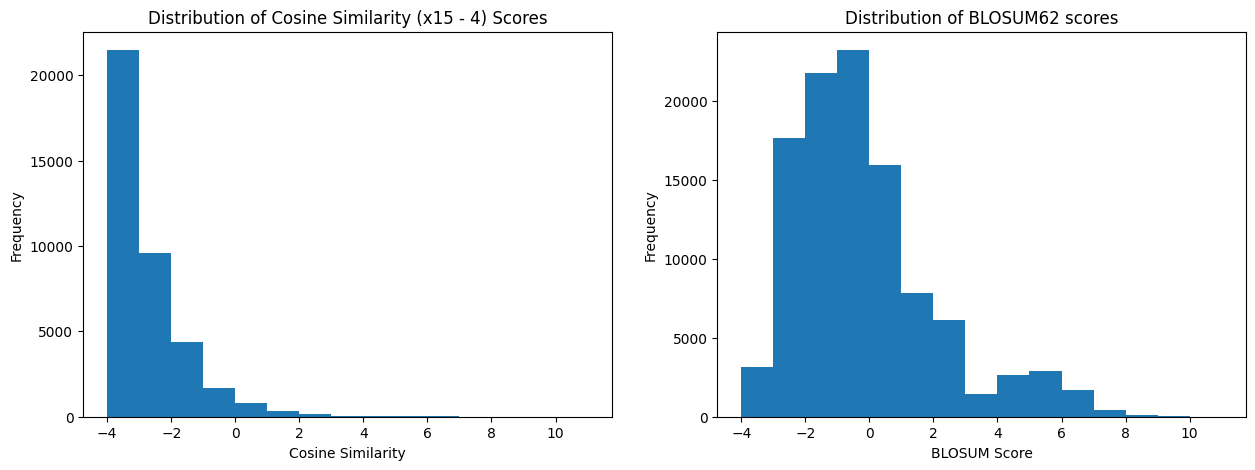

In [14]:
import matplotlib.pyplot as plt

# Compare distribution of cosine scores to distribution of BLOSUM scores
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].hist(cos_scores, bins = [i for i in range(-4, 12)])
axes[0].set_title('Distribution of Cosine Similarity (x15 - 4) Scores')
axes[0].set_xlabel('Cosine Similarity')
axes[0].set_ylabel('Frequency')
axes[1].hist(blosum_scores, bins = [i for i in range(-4, 12)])
axes[1].set_title('Distribution of BLOSUM62 scores')
axes[1].set_xlabel('BLOSUM Score')
axes[1].set_ylabel('Frequency')

In [49]:
from Bio import Align, AlignIO
from utility import write_align

# Parse fasta files for sequences and ids
seq1, id1 = parse_fasta('sequences/BB50012_1.fa')
seq2, id2 = parse_fasta('sequences/BB50012_2.fa')

# Use Biopython to get global alignment
aligner = Align.PairwiseAligner()
aligner.substitution_matrix = Align.substitution_matrices.load("BLOSUM62")
alignments = aligner.align(seq1, seq2)
align = alignments[0]
align1, align2 = align[0], align[1]
write_align(align1, align2, id1, id2, 'biopython')